# Catboost Modelling

In this notebook, a final sales forecasting model based on the CatBoost algorithm is created. More information can be found here: https://catboost.ai/

Just as the Random Forest model, the final model is also a tree-based model. These types of algorithms lend themselves well to predicting target features that are not normally distributed, as is the case with sales here. Moreover, CatBoost is specifically tailored to datasets with many categorical variables. With the expception of weather and lag variables, this dataset mainly contains categorical features, including dummy variables.

Given the flexibility of CatBoost, no additional preprocessing is necessary. It can handle object (categorical) variables, missing values and responds well to non-normally distributed target variables.

In [1]:
pip install catboost sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.1/134.1 kB 9.2 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.patches import Patch
import seaborn as sns
import datetime as dt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error

from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold
from statsmodels.tsa.stattools import adfuller

from catboost import CatBoostRegressor
import catboost as cb
#import optuna

In [4]:
# for google colab
#!unrar x drive/MyDrive/sweet-spot-donut-sales-forecasting.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from drive/MyDrive/sweet-spot-donut-sales-forecasting.rar

Extracting  functions_model.py                                             0%  OK 
Extracting  functions_vis.py                                               0%  OK 
Extracting  train_df.csv                                                  99%  OK 
Extracting  test_df.csv                                                  100%  OK 
All OK


In [2]:
%run functions_model.py
%run functions_vis.py

In [3]:
pd.set_option("display.max_columns", None)

### Loading the dataset

In [5]:
d = pd.read_csv("data/train_df.csv")
d_test = pd.read_csv("data/test_df.csv")

In [6]:
d['date'] = pd.to_datetime(d['date'])
d_test['date'] = pd.to_datetime(d_test['date'])

### Creating validation dataset

A validation set, containing the last 7 days of the entire training dataset, is created. The validation set is used for evaluation purposes and early stopping in the CatBoost model.

In [7]:
train, val = create_val_set(d)

## Modelling

#### Selecting features

In order for the CatBoost algorithm to recognize categorical features, all variables are saved either as categorical or numerical. The date variable will serve as the index, while the lag features will only be used in the training and validation, but not the test dataset.

In [109]:
date = ["date"]

catfeat = ["store_name","item_category","hol_pub","hol_school","weekday","day","month","year","week_year","nye","valentines_day","halloween", "street_market","public_space","box_deal"]

numfeat = ["days_back","temperature_2m_mean","sunshine_duration","precipitation_hours"]

lag = ["lag1","lag2", "lag7"]

Two types of sets were created:

1. The first type of train, validation and test datasets contains all features at the day, store and product level.
2. The second type contains all features only at the day and store level. The different product categories were removed and **only total daily sales** per store are kept.

In [12]:
x_train = train[date + catfeat + numfeat + lag]
x_train = x_train.set_index("date")
x_train_daily = x_train[(x_train["item_category"] == "daily total")].drop("item_category", axis = 1)
y_train = train['total_amount']
y_train_daily = train[(train["item_category"] == "daily total")]['total_amount']

x_val = val[date + catfeat + numfeat + lag]
x_val = x_val.set_index("date")
x_val_daily = x_val[(x_val["item_category"] == "daily total")].drop("item_category", axis = 1)
y_val = val['total_amount']
y_val_daily = val[(val["item_category"] == "daily total") ]['total_amount']

x_test = d_test[date + catfeat + numfeat]
x_test = x_test.set_index("date")
x_test_daily = x_test[(x_test["item_category"] == "daily total")].drop("item_category", axis = 1)
y_test = d_test['total_amount']
y_test_daily = d_test[(d_test["item_category"] == "daily total")]['total_amount']

In [ ]:
#catfeat.remove("item_category")

#### Converting holiday features to integer

In [13]:
x_train["hol_pub"] = x_train["hol_pub"].apply(np.int64)
x_train["hol_school"] = x_train["hol_school"].apply(np.int64)
x_train_daily["hol_pub"] = x_train_daily["hol_pub"].apply(np.int64)
x_train_daily["hol_school"] = x_train_daily["hol_school"].apply(np.int64)

x_val["hol_pub"] = x_val["hol_pub"].apply(np.int64)
x_val["hol_school"] = x_val["hol_school"].apply(np.int64)
x_val_daily["hol_pub"] = x_val_daily["hol_pub"].apply(np.int64)
x_val_daily["hol_school"] = x_val_daily["hol_school"].apply(np.int64)

x_test["hol_pub"] = x_test["hol_pub"].apply(np.int64)
x_test["hol_school"] = x_test["hol_school"].apply(np.int64)
x_test_daily["hol_pub"] = x_test_daily["hol_pub"].apply(np.int64)
x_test_daily["hol_school"] = x_test_daily["hol_school"].apply(np.int64)

The train and target variables are concatenated to obtain a train and test set at the daily sales level, without the individual product categories.

In [14]:
train_daily = pd.concat([x_train_daily.reset_index(), y_train_daily.reset_index(drop= True)], axis = 1)

test_daily = pd.concat([x_test_daily.reset_index(), y_test_daily.reset_index(drop= True)], axis = 1)

### Hyperparameter Tuning with Cross-validation


Training tree-based algorithm often leads to overfitting. In order to create a generalizable model, it is necessary to "prune" the trees by putting constraints on how well they can learn from the data. The following hyperparameters are tuned in the step below:

* Number of trees
* Learning rate
* L2 leaf regularization
* Tree depth (number of levels)
* Proportion of the sample used for each tree
* Proportion of the features used for each tree
* A minimum amount of datapoints in a leaf before a split can occur
* Minimum child weight


In [10]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
from sktime.split import ExpandingWindowSplitter
from sktime.utils import plot_windows
from sktime.utils._testing.hierarchical import _make_hierarchical
from sktime.transformations.series.summarize import WindowSummarizer

In [12]:
train_2 = train[date + catfeat + numfeat]
train_2 = train_2[train_2["item_category"] != "daily total"]
train_2 = pd.concat([train_2, train[train["item_category"] != "daily total"]["total_amount"]], axis = 1)



In [13]:
agg_columns = train_2.columns.difference(['date', 'store_name', 'item_category'] + ["total_amount"])
agg_dict = {col: "first" for col in agg_columns}
agg_dict["total_amount"] = "sum"

train_2 = train_2.groupby(['date', 'store_name', 'item_category']).agg(agg_dict).reset_index().sort_values(by = "date", ascending = False).reset_index(drop = True)
train_2 = train_2.set_index(["store_name","item_category","date"]).sort_index()


**Cross-validation**

In [138]:
def prepro_data (train):

  groups = []
  train_2_upd = []
  train_2_wind_upd = []
  all_dates_list = []

  for (store, item_category), group in train.groupby(level=['store_name', 'item_category']):
    groups.append(((store, item_category),group))

  for i in range(len(groups)):
    train_2_upd.append(groups[i][1].reset_index().set_index("date"))

  #for i in range(len(train_2_upd)):
  #  all_dates = pd.date_range(start=train_2_upd[i].index.min(),
  #                          end=train_2_upd[i].index.max(), freq='D')
  #  all_dates_list.append(all_dates)

  #for i in range(len(train_2_upd)):
  #  train_2_upd.append(train_2_upd[i].reindex(all_dates_list[i]))

  #for i in range(len(train_2_upd)):
  #  train_2_upd[i].index.name = "date"

  #train_2_upd = train_2_upd[37:]

  #for i in range(len(train_2_upd)):
  #  train_2_upd[i]["store_name"] = train_2_upd[i]["store_name"].ffill()
  #  train_2_upd[i]["item_category"] = train_2_upd[i]["item_category"].ffill()
  #  train_2_upd[i] = train_2_upd[i].ffill()

  for i in range(len(train_2_upd)):
    train_2_upd.append(train_2_upd[i].reset_index().set_index(["store_name","item_category","date"]))

  train_2_upd = train_2_upd[37:]


  train_2_wind_upd = train_2_upd.copy()

  kwargs = {"lag_feature": {
      "lag":[1,2,3],
      "mean": [[1,7], [1, 15], [1,30]],
      "std": [[1,4]]
      },
      "target_cols":["total_amount"]}

  transformer = WindowSummarizer(**kwargs)

  for i in range(len(train_2_wind_upd)):
    train_2_wind_upd[i] = transformer.fit_transform(train_2_wind_upd[i])
    train_2_wind_upd[i] = pd.concat([train_2_upd[i]["total_amount"], train_2_wind_upd[i]], axis = 1)
    train_2_wind_upd[i] = train_2_wind_upd[i].dropna()

  catfeat_new = ["hol_pub","hol_school","weekday","day","month","year","week_year",
                 "nye","valentines_day","halloween", "street_market","public_space","box_deal"]
  
  for i in range(len(train_2_wind_upd)):
    train_2_wind_upd[i][catfeat_new] = train_2_wind_upd[i][catfeat_new].astype(int)
    train_2_wind_upd[i][catfeat_new] = train_2_wind_upd[i][catfeat_new].astype("category")

  return train_2_wind_upd



In [139]:
train_2_wind_upd = prepro_data(train_2)

In [120]:
train_2_wind_upd[1].iloc[(train_2_wind_upd[1].index.get_level_values("date") == "2022-11-05") |
                          (train_2_wind_upd[1].index.get_level_values("date") == "2022-11-06") |
                         (train_2_wind_upd[1].index.get_level_values("date") == "2022-11-07") |
                         (train_2_wind_upd[1].index.get_level_values("date") == "2022-11-08") ]

total_amount  total_amount_lag_1  \
store_name item_category date                                           
Altona     mixed         2022-11-05           550               296.0   
                         2022-11-07           208               550.0   
                         2022-11-08           146               208.0   

                                     total_amount_lag_2  total_amount_lag_3  \
store_name item_category date                                                 
Altona     mixed         2022-11-05               216.0               212.0   
                         2022-11-07               296.0               216.0   
                         2022-11-08               550.0               296.0   

                                     total_amount_mean_1_7  \
store_name item_category date                                
Altona     mixed         2022-11-05             403.714286   
                         2022-11-07             383.428571   
                         2022-11-08             342.857143   

                                     total_amount_mean_1_15  \
store_name item_category date                                 
Altona     mixed         2022-11-05              378.933333   
                         2022-11-07              385.600000   
                         2022-11-08              351.066667   

                                     total_amount_mean_1_30  \
store_name item_category date                                 
Altona     mixed         2022-11-05              391.333333   
                         2022-11-07              394.866667   
                         2022-11-08              391.733333   

                                     total_amount_std_1_4 box_deal day  \
store_name item_category date                                            
Altona     mixed         2022-11-05             39.799497        1   5   
                         2022-11-07            159.108977        1   7   
                         2022-11-08            160.011458        1   8   

                                     days_back halloween hol_pub hol_school  \
store_name item_category date                                                 
Altona     mixed         2022-11-05        566         0       0          0   
                         2022-11-07        564         0       0          0   
                         2022-11-08        563         0       0          0   

                                    month nye  precipitation_hours  \
store_name item_category date                                        
Altona     mixed         2022-11-05    11   0                  1.0   
                         2022-11-07    11   0                  4.0   
                         2022-11-08    11   0                  1.0   

                                    public_space street_market  \
store_name item_category date                                    
Altona     mixed         2022-11-05            1             0   
                         2022-11-07            1             0   
                         2022-11-08            1             0   

                                     sunshine_duration  temperature_2m_mean  \
store_name item_category date                                                 
Altona     mixed         2022-11-05           7.907053                  8.0   
                         2022-11-07           1.042258                 11.1   
                         2022-11-08           6.053736                 13.0   

                                    valentines_day week_year weekday  year  
store_name item_category date                                               
Altona     mixed         2022-11-05              0        44       5  2022  
                         2022-11-07              0        45       0  2022  
                         2022-11-08              0        45       1  2022

In [21]:
train_2_wind_upd[1][1].iloc[(train_2_wind_upd[1][1].index.get_level_values("date") == "2022-11-05") |
                          (train_2_wind_upd[1][1].index.get_level_values("date") == "2022-11-06") |
                         (train_2_wind_upd[1][1].index.get_level_values("date") == "2022-11-07") |
                         (train_2_wind_upd[1][1].index.get_level_values("date") == "2022-11-08") ]

total_amount  total_amount_lag_1  \
store_name item_category date                                           
Altona     mixed         2022-11-05         550.0               296.0   
                         2022-11-06         550.0               550.0   
                         2022-11-07         208.0               550.0   
                         2022-11-08         146.0               208.0   

                                     total_amount_lag_2  total_amount_lag_3  \
store_name item_category date                                                 
Altona     mixed         2022-11-05               216.0               212.0   
                         2022-11-06               296.0               216.0   
                         2022-11-07               550.0               296.0   
                         2022-11-08               550.0               550.0   

                                     total_amount_mean_1_7  \
store_name item_category date                                
Altona     mixed         2022-11-05             403.714286   
                         2022-11-06             383.428571   
                         2022-11-07             391.714286   
                         2022-11-08             327.428571   

                                     total_amount_mean_1_15  \
store_name item_category date                                 
Altona     mixed         2022-11-05              378.933333   
                         2022-11-06              385.600000   
                         2022-11-07              373.866667   
                         2022-11-08              353.200000   

                                     total_amount_mean_1_30  \
store_name item_category date                                 
Altona     mixed         2022-11-05              391.333333   
                         2022-11-06              394.866667   
                         2022-11-07              403.133333   
                         2022-11-08              387.000000   

                                     total_amount_std_1_4 box_deal day  \
store_name item_category date                                            
Altona     mixed         2022-11-05             39.799497        1   5   
                         2022-11-06            159.108977        1   5   
                         2022-11-07            172.854467        1   7   
                         2022-11-08            175.761202        1   8   

                                     days_back halloween hol_pub hol_school  \
store_name item_category date                                                 
Altona     mixed         2022-11-05      566.0         0       0          0   
                         2022-11-06      566.0         0       0          0   
                         2022-11-07      564.0         0       0          0   
                         2022-11-08      563.0         0       0          0   

                                    month nye  precipitation_hours  \
store_name item_category date                                        
Altona     mixed         2022-11-05    11   0                  1.0   
                         2022-11-06    11   0                  1.0   
                         2022-11-07    11   0                  4.0   
                         2022-11-08    11   0                  1.0   

                                    public_space street_market  \
store_name item_category date                                    
Altona     mixed         2022-11-05            1             0   
                         2022-11-06            1             0   
                         2022-11-07            1             0   
                         2022-11-08            1             0   

                                     sunshine_duration  temperature_2m_mean  \
store_name item_category date                                                 
Altona     mixed         2022-11-05           7.907053                  8.0   
                 

In [121]:
train_2_final = pd.concat(train_2_wind_upd).reset_index().sort_values("date").set_index("date")

**Time-series cross-validation split**

When performing k-fold cross-validation in a time-series context, the data musn't be shuffled as in a regular cross-validation scenario. Instead, a forecasting horizon has to be defined for each fold, which serves as the validation set. It always comes after the training set chronologically. Because predicting donut sales for more than one week in advance is a difficult endeavor and will most likely lead to imprecise results, the forecasting horizon for this problem was set to 7 days.

In [73]:
def create_train_validation_folds(df):
    last_val_date = df.date.max()
    cv = []
    for n in range(5):
        first_val_date = last_val_date - dt.timedelta(days=6)
        train_index = df[df.date<first_val_date].index
        val_index = df[(df.date>=first_val_date) & (df.date<=last_val_date)].index
        cv.append((train_index,val_index))
        last_val_date = first_val_date - dt.timedelta(days=1)
    cv = cv[::-1]
    return cv

In [122]:
create_train_validation_folds(train_2_final.reset_index())

[(Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
         ...
         28899, 28900, 28901, 28902, 28903, 28904, 28905, 28906, 28907, 28908],
        dtype='int64', length=28909),
  Index([28909, 28910, 28911, 28912, 28913, 28914, 28915, 28916, 28917, 28918,
         ...
         29123, 29124, 29125, 29126, 29127, 29128, 29129, 29130, 29131, 29132],
        dtype='int64', length=224)),
 (Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
         ...
         29123, 29124, 29125, 29126, 29127, 29128, 29129, 29130, 29131, 29132],
        dtype='int64', length=29133),
  Index([29133, 29134, 29135, 29136, 29137, 29138, 29139, 29140, 29141, 29142,
         ...
         29347, 29348, 29349, 29350, 29351, 29352, 29353, 29354, 29355, 29356],
        dtype='int64', length=224)),
 (Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
         ...
         29347, 29348, 29349, 29350, 29351, 29352, 29353, 29354, 29355

In [76]:
def create_train_validation_dataset(df):
    last_val_date = df.date.max()
    cv = []
    for n in range(5):
        first_val_date = last_val_date - dt.timedelta(days=6)
        train_fold = df[df.date<first_val_date]
        val_fold = df[(df.date>=first_val_date) & (df.date<=last_val_date)]
        cv.append((train_fold,val_fold))
        last_val_date = first_val_date - dt.timedelta(days=1)
    cv = cv[::-1]
    return cv

In [ ]:
for i in range(5):
  globals()[f"train_{i}"], globals()[f"val_{i}"] = create_train_validation_dataset(train_daily)[i]

In [161]:
train_2_final.groupby(["store_name","item_category"])

In [162]:


#for i in range(len(train_2_wind_upd)):
#    train_2_wind_upd[i] = (list(train_2.groupby(["store_name","item_category"]))[i][0], train_2_wind_upd[i])

def window_splitter_prep(train, validation_length, num_folds):
    
    def get_initial_window_size(store_group, validation_length, num_folds):
        total_periods = len(store_group.index.get_level_values('date').unique())
        initial_window = total_periods - validation_length * num_folds
        return initial_window

    cv_list = []
    
    for (store,item), group in train.groupby(["store_name","item_category"]):

        # Calculate the initial window size for the current store
        initial_window = get_initial_window_size(group, validation_length, num_folds)

        # Initialize the ExpandingWindowSplitter for the current group
        splitter = ExpandingWindowSplitter(
            initial_window=initial_window,
            step_length=7,
            fh=list(range(1, 7 + 1))
        )

        cv_list.append(({f"{store}"+"_"+f"{item}":splitter},
                            {f"{store}"+"_"+f"{item}":group}))
    
    return cv_list


In [164]:
cv_list = window_splitter_prep(train_2_final, validation_length = 7, num_folds = 5)

The graph below depicts the time-series cross-validation process visually. The forecsasting horizon of 7 days from the first fold becomes part of the training set in the second cross-validation fold, while the next 7 days serve as the second validation set. Five folds were chosen in total, meaning there are 35 validation days on which the training data is evaluated. 

</br>

**Note:** 

---

When making time-series forecasting on a test dataset, predictions are often done recursively. This means that the model does not make predictions for all points in a forecasting horizon at once (7 days in this case), but does so day by day. The reason for that is that when window variables - such as lagged features or rolling averages of the target variable (donut sales) - are considered as explanatory variables, they won't actually exist in the test dataset. They are, in that case, calculated based on future target variable values which are yet to be predicted. 

This type of assessment will be performed on the testing dataset at the end of the notebook . However, the cross-validation process in this case would not only involve recursive predictions, but would also have to accommodate hierarchical data structures (i.e. one store per one product per one day). 

In order to simplify this task, no recursive predictions will be carried out on either of the five validation folds at this point. While this won't yield the most optimal predictions, performing time-series cross-validation can still produce good evaluation results.

To make the resulst more rigorous, recursive forecasting in the cross-validation scenario should be executed in the future. 

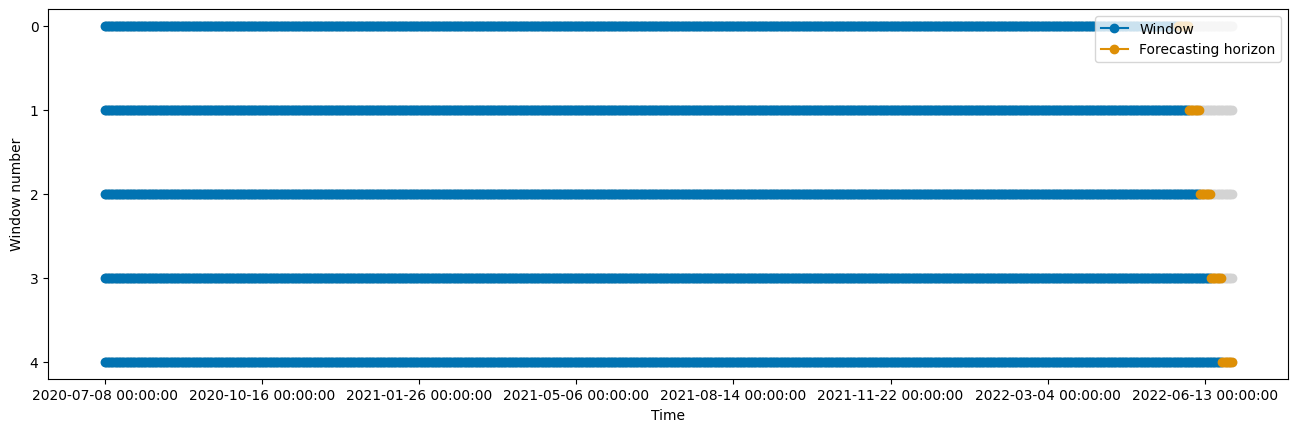

In [171]:
for i in range(32,33):
    plot_windows(list(cv_list[i][0].values())[0], list(cv_list[i][1].values())[0]["total_amount"])

**Hyperparameter tuning**

Given that CatBoost is a tree-based model, there is a large number of hyperparameters that can be tuned. For this task, the following hyperparameters were chosen:

* Number of trees (estimators)
* Learning rate
* L2 leaf regularization
* Tree depth
* Percentage of datapoint to be used in each tree (bootstrapping)
* Percentage of features to be used in each tree
* Smallest number of data to be used in a leaf before a split is made

In [149]:
params = {
    'estimator__n_estimators': np.arange(250,1000,1),
    "estimator__learning_rate": np.logspace(-4, -1),
    "estimator__l2_leaf_reg": np.linspace(2, 30),
    "estimator__depth":np.arange(3,17,1),
    "estimator__subsample": np.linspace(0.05, 1.0),
    "estimator__colsample_bylevel": np.linspace(0.05, 1.0),
    "estimator__min_data_in_leaf": np.arange(10, 51, 1)}

In [ ]:
model = cb.CatBoostRegressor(cat_features=catfeat)

In [ ]:
randomized_search_result = model.randomized_search(params,
                                                  # n_iter=30,
                                                   X= x_train_daily,
                                                   y= y_train_daily,
                                                   cv = create_train_validation_folds(train_daily),
                                                   plot=True,
                                                   verbose = 500,
                                                   calc_cv_statistics=True)

In [ ]:
pd.DataFrame(randomized_search_result.get("cv_results"))

In [ ]:
randomized_search_result.get("params")

In [ ]:
#def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 2, 30),
        "depth": trial.suggest_int("depth", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "min_child_weight": trial.suggest_int(1, 300)
    }

    model = CatBoostRegressor(**params, silent=True, allow_writing_files = False, cat_features = catfeat)

    model_cv = optuna.integration.OptunaSearchCV(estimator = model, param_distributions = params, cv = create_train_validation_folds(train_daily), n_jobs = -1, n_trials = 30)

    #model.fit(x_train_daily, y_train_daily, eval_set = (create_train_validation_folds_cat(x_train_daily_totalamount)), cat_features = catfeat, verbose = 1000, plot = False)

    # y_val_pred_daily = model_cv.predict(x_val_daily)

    #rmse = mean_squared_error(y_val_daily, y_val_pred_daily, squared=False)

    #return rmse

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=30)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

In [153]:
y_train_2_final = train_2_final["total_amount"]
X_train_2_final = train_2_final.drop("total_amount", axis = 1)

In [ ]:
# Best model

model = CatBoostRegressor(n_estimators = 2620, learning_rate = 0.0487,
 depth = 5, subsample = 0.21, colsample_bylevel = 0.2, min_data_in_leaf = 21, early_stopping_rounds = 69, cat_features = catfeat, random_state = 123, allow_writing_files = True)

model.fit(x_train_daily, y_train_daily, eval_set=(x_val_daily, y_val_daily), verbose = 500, plot = True)

### Feature importances

In [ ]:
model.get_feature_importance(prettified=True).plot(x = "Feature Id", y = "Importances", kind = "bar")

### Evaluation metrics train and validation set

In [ ]:
y_train_pred = model.predict(x_train_daily)
print(f"R-squared train: {round(r2_score(y_train_daily, y_train_pred),6)}")
print(f"MAPE train: {round(100*mean_absolute_percentage_error(y_train_daily, y_train_pred),2)}\n")

y_val_pred = model.predict(x_val_daily)
print(f"R-squared validation: {round(r2_score(y_val_daily, y_val_pred),6)}")
print(f"MAPE validation: {round(100*mean_absolute_percentage_error(y_val_daily, y_val_pred),2)}")

# Test dataset

In [ ]:
x_test_daily_totalamount, y_test_pred =  pred_test(train = x_train_daily_totalamount, test = x_test_daily_totalamount, model = model, numfeat = numfeat, catfeat = catfeat)

### Residuals by store

In [ ]:
difference_df = diff_overview(data = x_test_daily_totalamount, pred = y_test_pred, stores = all)

### Residual Plot Analysis

In [ ]:
sns.scatterplot(data = difference_df, x = "Predicted", y = "Stand_resid")

plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Sales (Daily total)")
plt.ylabel("Standardized Residuals")

plt.show()

### Evaluation metrics train and test set

In [ ]:
fit_overview(ytrain = y_train_daily, ytrainpred = y_train_pred, ytest = y_test_daily, ytestpred = y_test_pred)

In [ ]:
mape_stores(x_test_daily_totalamount, y_test_pred)

### Visualisation of predictions

In [ ]:
df_predicted = pd.concat(
    [
    difference_df[["Date","Store name","Observed","Predicted"]].rename(columns = {"Date":"date","Store name":"store_name","Observed":"total_amount"}),
    d[(d["date"] >= pd.to_datetime("2024-05-01")) & (d["item_category"] == "daily total")][["date","store_name","total_amount"]]
    ]
    )

In [ ]:
ts_predicted(df_predicted)